<i><b>Public-AI</b></i>

# 필터 시각화하기


### _Objective_

* 각 필터가 어떤 형태에 강하게 반응하는지를 파악하기 위해, 각 필터 별로 가장 반응이 강한 이미지를 생성해보도록 하겠습니다.


In [2]:
%matplotlib inline
import os
import cv2
import numpy as np
import tensorflow as tf

from zipfile import ZipFile

import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## Dataset) Cat VS Dog Dataset

개와 고양이를 분류하기 위해, 아래와 같이 데이터셋을 준비하였습니다.<Br> 

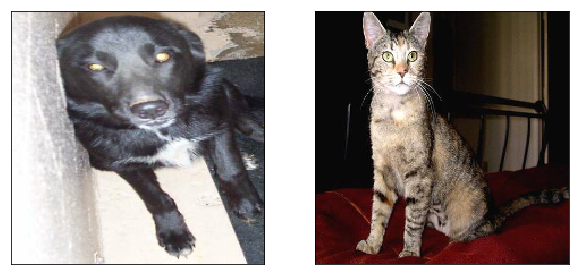

In [3]:
data_dir = "cat-vs-dog"
fpath = get_file("cat-vs-dog.zip", 
                 "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cat-vs-dog.zip")

if not os.path.exists(data_dir):
    with ZipFile(fpath,'r') as f:
        f.extractall(data_dir)
        
# 이미지 시각화하기 
dog_image = cv2.imread(
    os.path.join(data_dir,'train','dog','dog.10000.jpg'))
dog_image = cv2.cvtColor(dog_image, cv2.COLOR_BGR2RGB)
dog_image = cv2.resize(dog_image, (224,224))

cat_image = cv2.imread(
    os.path.join(data_dir,'train','cat','cat.10000.jpg'))
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)
cat_image = cv2.resize(cat_image, (224,224))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(cat_image)
plt.show()        

<br><br>

# \[ 필터 시각화  \]
---

* Convolution Layer의 각 층에서 어떤 패턴들을 잡는지를 알기 위해서는, 은닉층 시각화보다는 좀 더 복잡한 방법이 필요합니다.
* 필터 시각화라 불리는 이 방법은 각 층에서 은닉층을 가장 활성화시키는 이미지의 패턴을 경사상승법을 통해 찾아가는 방식입니다.

<br>

## 1. Pretrained Model 가져오기

이번에도 VGG Network를 가져오도록 하겠습니다.

### (1) VGG 모델 가져오기

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=True)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### (2) 은닉 레이어 가져오기

In [5]:
# 입력 텐서 가져오기
inputs = vgg16.input

# 은닉층 텐서 가져오기
conv1_1 = vgg16.get_layer('block1_conv1').output
conv1_2 = vgg16.get_layer('block1_conv2').output

conv2_1 = vgg16.get_layer('block2_conv1').output
conv2_2 = vgg16.get_layer('block2_conv2').output

conv3_3 = vgg16.get_layer('block3_conv3').output
conv4_3 = vgg16.get_layer('block4_conv3').output

conv5_3 = vgg16.get_layer('block5_conv3').output

<br>

## 2. 필터 시각화를 위한 모델 구현하기

CNN Layer이 학습한 필터를 조사하는 하나의 방법은 각 필터가 반응하는 시각적 패턴을 직접 그려 보는 것입니다. 빈 입력 이미지에서 시작해서 특정 필터의 출력값을 극대화하기 위해 입력 이미지를 조금씩 바꾸는 것입니다.<br>

즉 우리는 이때까지 Loss 값을 줄이는 방향으로 경사하강법을 적용한 것과 비슷하게<br>
특정 필터의 출력값을 늘리는 방향으로 경사상승법을 적용하는 것입니다.

### (1) 필터 시각화를 할 출력값 결정하기

3번째 Block의 3번째 Convolution 필터를 시각화해보도록 하겠습니다. <br> 그 중 9번째 필터를 시각화해보도록 하겠습니다.

In [6]:
from tensorflow.keras.models import Model

In [7]:
f_idx = 9

filter_map = conv3_3[:,:,:,f_idx]
model = Model(inputs, filter_map)

### (2) 빈 이미지 구성하기

랜덤 노이즈를 가한 빈 이미지를 구성합니다.<br>  가중치를 초기화할 때 무작위로 추출하는 것처럼, 이 또한 랜덤하게 추출합니다.<br> 

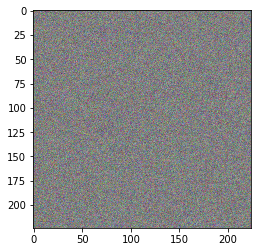

In [8]:
blank = tf.random.normal((1,224,224,3)) * 20 + 128.
plt.imshow(blank[0].numpy().astype(np.uint8))
plt.show()

### (3) 출력값이 극대화되도록 이미지를 조금씩 바꾸기

단지 차이는 경사하강법은 빼주었지만 경사상승법에서는 더해주는 방식으로 진행합니다. <br>텐서플로우에서 기울기값을 구하기 위해서는 tf.GradientTape()이라는 것을 이용해야 합니다.

In [9]:
from tqdm import tqdm

learning_rate = 20.
num_step = 100



****[optional]****

이를 가속화해주기 위해서는 우리는 `tf.function`이라는 텐서플로우에서 제공하는 컴파일을 이용할수도 있습니다.

In [10]:
@tf.function
def gradient_ascent(blank):
    # 구현
    return blank

In [11]:
learning_rate = 30.
num_step = 200

blank = tf.random.normal((1,224,224,3)) * 20 + 128.
for i in tqdm(range(num_step)):
    blank = gradient_ascent(blank)

100%|██████████| 200/200 [00:00<00:00, 1005.72it/s]


### (4) 필터 활성화 이미지를 시각화하기

In [12]:
def decode_image(image):
    image = np.array(image)
    image = image.squeeze() # (1,H,W,C) - >(H,W,C)로 바꾸어줌
    image -= image.mean()
    image /= image.std()
    
    image = (image - image.min())/(image.max()-image.min())
    return image

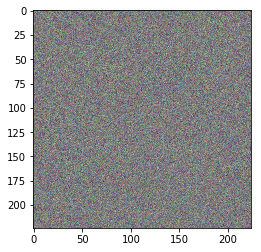

In [13]:
result = decode_image(blank.numpy())

plt.imshow(result)
plt.show()

### (5) 메소드로 구현하기

In [14]:
@tf.function
def generate_filter_pattern(model, num_step=100, learning_rate=100):
    blank = tf.random.normal((1,224,224,3)) * 20 + 128.    
    for i in range(num_step):
        with tf.GradientTape() as tape:
            tape.watch(blank)    
            output = model(blank)
        grads = tape.gradient(output, blank) 
        grads = grads / (tf.norm(grads) + 1e-5)
        blank = blank + learning_rate * grads # 경사 상승법
    return blank

In [15]:
model = Model(inputs, conv4_3[:,:,:,5])
output = generate_filter_pattern(model, learning_rate=100)

visualized = decode_image(output)
plt.imshow(visualized)
plt.show()

KeyboardInterrupt: 

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---